Populating the interactive namespace from numpy and matplotlib
INFO:tensorflow:Restoring parameters from saver/CAE/CAE-1000
restored from checkpoint CAE-1000


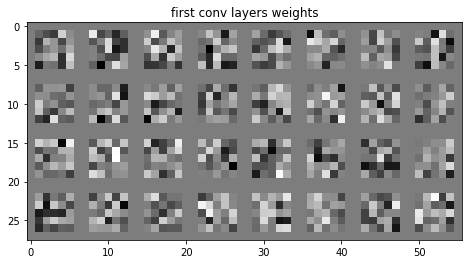

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


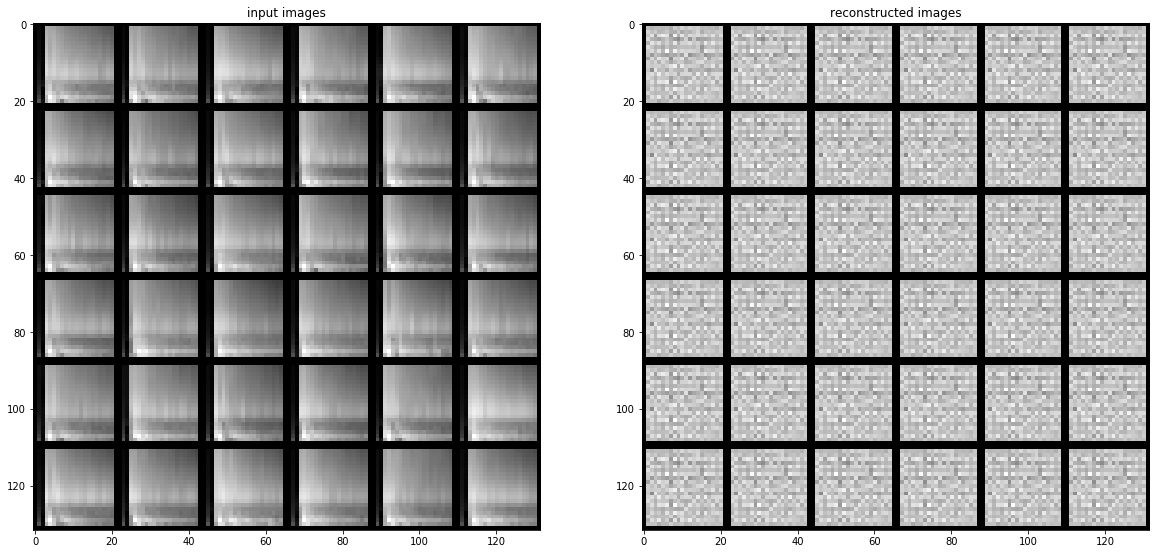

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from models import *
import os

%pylab inline

class ConvolutionalAutoencoder(object):
    """

    """
    def __init__(self):
        """
        build the graph
        """
        # place holder of input data
        x = tf.placeholder(tf.float32, shape=[None, 20, 20, 1])  # [#batch, img_height, img_width, #channels]

        # encode
        conv1 = Convolution2D([5, 5, 1, 32], activation=tf.nn.relu, scope='conv_1')(x)
        pool1 = MaxPooling(kernel_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', scope='pool_1')(conv1)
        conv2 = Convolution2D([5, 5, 32, 32], activation=tf.nn.relu, scope='conv_2')(pool1)
        pool2 = MaxPooling(kernel_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', scope='pool_2')(conv2)
        unfold = Unfold(scope='unfold')(pool2)
        encoded = FullyConnected(20, activation=tf.nn.relu, scope='encode')(unfold)
        # decode
        decoded = FullyConnected(5*5*32, activation=tf.nn.relu, scope='decode')(encoded)
        fold = Fold([-1, 5, 5, 32], scope='fold')(decoded)
        unpool1 = UnPooling((2, 2), output_shape=tf.shape(conv2), scope='unpool_1')(fold)
        deconv1 = DeConvolution2D([5, 5, 32, 32], output_shape=tf.shape(pool1), activation=tf.nn.relu, scope='deconv_1')(unpool1)
        unpool2 = UnPooling((2, 2), output_shape=tf.shape(conv1), scope='unpool_2')(deconv1)
        reconstruction = DeConvolution2D([5, 5, 1, 32], output_shape=tf.shape(x), activation=tf.nn.sigmoid, scope='deconv_2')(unpool2)

        # loss function
        loss = tf.nn.l2_loss(x - reconstruction)  # L2 loss

        # training
        training = tf.train.AdamOptimizer(1e-4).minimize(loss)

        #
        self.x = x
        self.reconstruction = reconstruction
        self.loss = loss
        self.training = training

    def train(self, passes, new_training=True):
        """

        :param batch_size:
        :param passes:
        :param new_training:
        :return:
        """
        pwd = os.getcwd()
        tfrecord_file_path = pwd + "/SAE_input2.tfrecord"
        filename_queue = tf.train.string_input_producer(
                                      tf.train.match_filenames_once(tfrecord_file_path),
                                      shuffle=True, num_epochs=None)

        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)
        features = tf.parse_single_example(serialized_example,
                                               features={'data': tf.FixedLenFeature([], tf.string)}) 
        img = tf.decode_raw(features['data'], tf.uint8)
        img = tf.image.convert_image_dtype(img,tf.float32)
        img = tf.reshape(img, [20, 20, 1])
        input_batch = tf.train.shuffle_batch([img],batch_size=10,capacity=500,min_after_dequeue=250,num_threads=1)

        with tf.Session() as sess:
            # prepare session
            if new_training:
                saver, global_step = Model.start_new_session(sess)
            else:
                saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/CAE/checkpoint')

            tf.local_variables_initializer().run()
            tf.global_variables_initializer().run()
            coord = tf.train.Coordinator()
            thread = tf.train.start_queue_runners(sess=sess,coord=coord) 
            
            # start training
            for step in range(1+global_step, 1+passes+global_step):
                x = input_batch.eval()
                self.training.run(feed_dict={self.x: x})

                if step % 100 == 0:
                    loss = self.loss.eval(feed_dict={self.x: x})
                    print("pass {}, training loss {}".format(step, loss))

                if step % 1000 == 0:  # save weights
                    saver.save(sess, 'saver/CAE/CAE', global_step=step)
                    print('checkpoint saved')
            
            coord.request_stop()
            coord.join(thread)

    def reconstruct(self):
        """

        """
        def weights_to_grid(weights, rows, cols):
            """convert the weights tensor into a grid for visualization"""
            height, width, in_channel, out_channel = weights.shape
            padded = np.pad(weights, [(1, 1), (1, 1), (0, 0), (0, rows * cols - out_channel)],
                            mode='constant', constant_values=0)
            transposed = padded.transpose((3, 1, 0, 2))
            reshaped = transposed.reshape((rows, -1))
            grid_rows = [row.reshape((-1, height + 2, in_channel)).transpose((1, 0, 2)) for row in reshaped]
            grid = np.concatenate(grid_rows, axis=0)

            return grid.squeeze()

        with tf.Session() as sess:
            saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/CAE/checkpoint')

            # visualize weights
            first_layer_weights = tf.get_default_graph().get_tensor_by_name("conv_1/kernel:0").eval()
            grid_image = weights_to_grid(first_layer_weights, 4, 8)

            fig, ax0 = plt.subplots(ncols=1, figsize=(8, 4))
            ax0.imshow(grid_image, cmap=plt.cm.gray, interpolation='nearest')
            ax0.set_title('first conv layers weights')
            plt.show()

            # visualize results
            pwd = os.getcwd()
            tfrecord_file_path = pwd + "/SAE_input2.tfrecord"
            filename_queue = tf.train.string_input_producer(
                                          tf.train.match_filenames_once(tfrecord_file_path),
                                          shuffle=True, num_epochs=None)

            reader = tf.TFRecordReader()
            _, serialized_example = reader.read(filename_queue)
            features = tf.parse_single_example(serialized_example,
                                                   features={'data': tf.FixedLenFeature([], tf.string)}) 
            img = tf.decode_raw(features['data'], tf.uint8)
            img = tf.image.convert_image_dtype(img,tf.float32)
            img = tf.reshape(img, [20, 20, 1])
            input_batch = tf.train.batch([img],batch_size=36)
            
            with tf.Session() as sess:
                tf.local_variables_initializer().run()
                tf.global_variables_initializer().run()
                coord = tf.train.Coordinator()
                thread = tf.train.start_queue_runners(sess=sess,coord=coord) 
                
                x = input_batch.eval()
                org, recon = sess.run((self.x, self.reconstruction), feed_dict={self.x: x})

                input_images = weights_to_grid(org.transpose((1, 2, 3, 0)), 6, 6)
                recon_images = weights_to_grid(recon.transpose((1, 2, 3, 0)), 6, 6)

                fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
                ax0.imshow(input_images, cmap=plt.cm.gray, interpolation='nearest')
                ax0.set_title('input images')
                ax1.imshow(recon_images, cmap=plt.cm.gray, interpolation='nearest')
                ax1.set_title('reconstructed images')
                plt.show()

                coord.request_stop()
                coord.join(thread)
            

def main():
    conv_autoencoder = ConvolutionalAutoencoder()
    #conv_autoencoder.train(passes=10000, new_training=True)
    conv_autoencoder.reconstruct()

if __name__ == '__main__':
    main()